# Installing Necessary Libraries

In [ ]:
!pip install tensorflow-gpu
!pip install keras
!pip install python=opencv
!pip install matplotlib
!pip install numpy

## Importing Necessary Libraries

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import zipfile

# Mounting G-Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Replace 'file_path.rar' with the path to your .rar file
file_path = '/content/drive/MyDrive/anime faces.zip'

# Unzip the file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content')


In [5]:
image_dir = "/content/anime faces/cropped"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
images[:2]

['/content/anime faces/cropped/35396_2011.jpg',
 '/content/anime faces/cropped/34550_2011.jpg']

In [6]:
#checking dataset length
len(images)

30750

# Checking avg dimension of all the images

In [7]:
#checking avg dimension of all the images
from PIL import Image
import os

# Directory containing your images
directory = '/content/anime faces/cropped'

# Get a list of all image files in the directory
image_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('png', 'jpg', 'jpeg', 'gif'))]

# Initialize variables to store total width and height
total_width = 0
total_height = 0

# Loop through each image and accumulate width and height
for image_file in image_files:
    with Image.open(image_file) as img:
        width, height = img.size
        total_width += width
        total_height += height

# Calculate average dimensions
avg_width = total_width / len(image_files)
avg_height = total_height / len(image_files)

print(f"Average width: {avg_width}, Average height: {avg_height}")

Average width: 104.88874796747967, Average height: 104.88832520325204


# Preprocessing

In [8]:
# preprocess
image_size = 64

def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    image = tf.reshape(image, shape = (image_size, image_size, 3,))
    return image

In [9]:
batch_size = 128
training_dataset = tf.data.Dataset.from_tensor_slices((images))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

In [10]:
len(training_dataset)

241

# Visualizing Some Of The images From Dataset

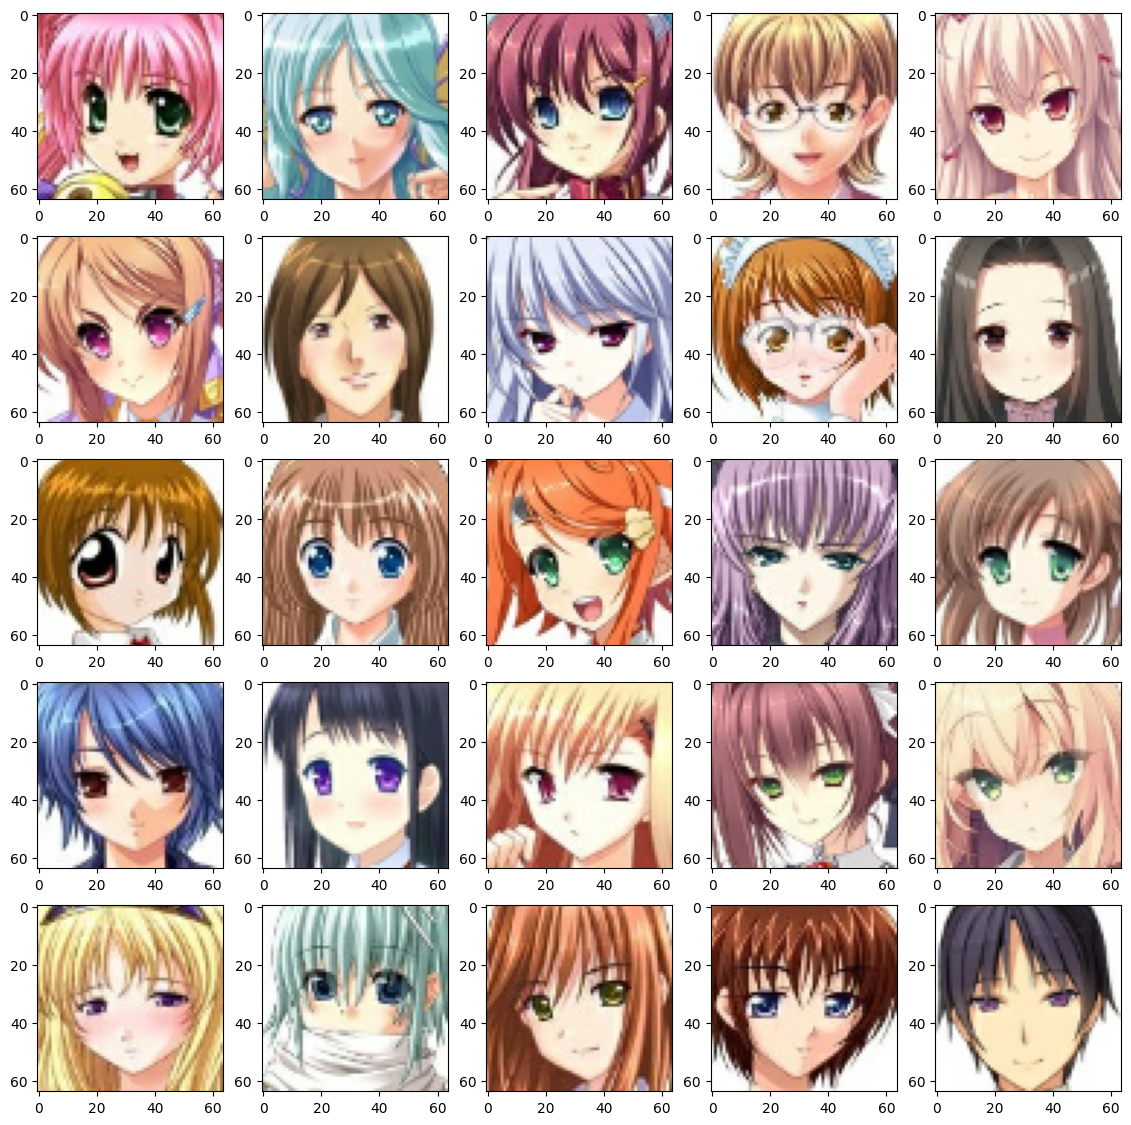

In [11]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

#Building The Model

In [12]:
# build the model
latent_dim = 512

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation, LeakyReLU
from keras.activations import selu
from keras.layers import Multiply, Add
from keras.optimizers import Adam
from keras import backend as K

In [14]:
K.clear_session()

# Encoder

In [15]:
encoder_input = Input(shape = (64,64,3))

x = Conv2D(32, kernel_size=5, activation = LeakyReLU(0.02), strides = 1, padding = 'same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [64,128,256,512]
for i in filter_size:
    x = Conv2D(i, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

# sampling layer
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps])

encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           2432      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           51264     ['batch_normalization[0]

# Decoder

In [16]:
# build the decoder

decoder = Sequential()
decoder.add(Dense(1024, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation = selu))
decoder.add(Reshape((4,4,512)))

decoder.add(Conv2DTranspose(256, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(3, (5,5), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_6 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 8192)              8396800   
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)         3277056   
 anspose)                                                        
                                                                 
 batch_normalization_7 (Bat  (None, 8, 8, 256)         1

# Defining Loss

In [17]:
# make loss function
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)

# Creating VAE by Combining Encoder & Decoder

In [18]:
# conbine encoder and decoder
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 512),                1380268   ['input_1[0][0]']             
                              (None, 512),                8                                       
                              (None, 512)]                                                        
                                                                                                  
 sequential (Sequential)     (None, 64, 64, 3)            1328302   ['encoder[0][2]']             
                                                          3                                     

# Making a function to save images while learning

In [19]:
# make a function to save images while learning
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = "/content/generated_faces/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()

# Training

In [20]:
# train vae

from keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 150

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])

            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())

            kl = sum(model.losses)
            kl_losses.append(kl.numpy())

            train_loss = 0.01 * kl + mse_loss

            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            if step % 240 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))

1/1 [==============================] - 3s 3s/step
Epoch:  1


Streaming output truncated to the last 5000 lines.
Epoch: 130 - Step: 122 - MSE loss: 0.009642574 - KL loss: 0.33189544
Epoch: 130 - Step: 123 - MSE loss: 0.009472091 - KL loss: 0.3324182
Epoch: 130 - Step: 124 - MSE loss: 0.009311873 - KL loss: 0.32908404
Epoch: 130 - Step: 125 - MSE loss: 0.009200041 - KL loss: 0.3317201
Epoch: 130 - Step: 126 - MSE loss: 0.0089444425 - KL loss: 0.3321545
Epoch: 130 - Step: 127 - MSE loss: 0.009533319 - KL loss: 0.32803532
Epoch: 130 - Step: 128 - MSE loss: 0.009807964 - KL loss: 0.33133352
Epoch: 130 - Step: 129 - MSE loss: 0.009699227 - KL loss: 0.33480993
Epoch: 130 - Step: 130 - MSE loss: 0.009355844 - KL loss: 0.33190358
Epoch: 130 - Step: 131 - MSE loss: 0.009535897 - KL loss: 0.33002102
Epoch: 130 - Step: 132 - MSE loss: 0.009755469 - KL loss: 0.33892757
Epoch: 130 - Step: 133 - MSE loss: 0.009572382 - KL loss: 0.34368718
Epoch: 130 - Step: 134 - MSE loss: 0.009616465 - KL loss: 0.33524847
Epoch: 130 - Step: 135 - MSE loss: 0.009661867 - KL lo

In [27]:
# Folder path to be zipped
folder_path = '/content/generated_faces/'

# Name for the zip file
zip_file_name = '/content/generated_faces.zip'

# Zip the folder
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_path))

GENERATING RANDOM ANIME FACES WITH DECODER

1/1 [==============================] - 0s 377ms/step
(64, 64, 3)


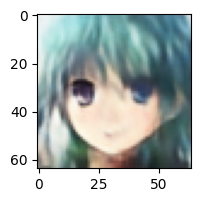

In [23]:
random_vector = tf.random.normal(shape = (1, latent_dim,))
prediction = decoder.predict(random_vector)
image = prediction[0] * 255
image = image.astype("int32")
print(image.shape)
# Display the image with a specified figure size
plt.figure(figsize=(2, 2))  # Specify the figure size
plt.imshow(image)
plt.show()

1/1 [==============================] - 0s 384ms/step


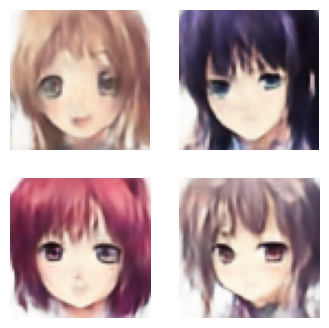

In [24]:
random_vector = tf.random.normal(shape = (4, latent_dim,))
prediction = decoder.predict(random_vector)
fig, axes = plt.subplots(2,2, figsize = (4,4))
idx = 0
for row in range(2):
    for column in range(2):
        image = prediction[idx] * 255
        image = image.astype("int32")
        axes[row, column].imshow(image)
        axes[row, column].axis("off")
        idx+=1